In [1]:
import sqlite3
from sqlalchemy import create_engine, MetaData, Table, select
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tabulate import tabulate



/var/folders/gd/kk24lb6504z0vmjkdhn96kch0000gn/T/ipykernel_70391/3812239147.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
%load_ext sql


In [3]:
# Connect to SQLite database
conn = sqlite3.connect(r'./data/vivino.db')
# Create a cursor object
cur = conn.cursor()

### We want to highlight 10 wines to increase our sales. Which ones should we choose and why?

In [4]:


cur.execute('''
    SELECT 
        toplists.*, 
        vintage_toplists_rankings.rank, 
        vintages.name AS vintage_name, 
        wines.name AS wine_name,
        countries.name AS country_name
    FROM 
        toplists
    INNER JOIN 
        vintage_toplists_rankings ON toplists.id = vintage_toplists_rankings.top_list_id
    INNER JOIN 
        vintages ON vintage_toplists_rankings.vintage_id = vintages.id
    INNER JOIN 
        wines ON vintages.wine_id = wines.id
    INNER JOIN 
        countries ON toplists.country_code = countries.code
    WHERE 
        toplists.name LIKE 'bestseller%'
    ORDER BY 
        vintage_toplists_rankings.rank
    LIMIT 10
''')

matching_entries = cur.fetchall()

table_data = []
for entry in matching_entries:
    toplist_name = entry[1]
    country_name = entry[-1]  
    rank = entry[3]
    vintage_name = entry[4]
    wine_name = entry[5]
    common_word = None
    extracted_name = None

    vintage_words = vintage_name.split()
    wine_words = wine_name.split()
    for word in wine_words:
        if word in vintage_words:
            common_word = word
            break

    if common_word:
        extracted_name = ' '.join(vintage_words[:vintage_words.index(common_word)])

    table_row = [toplist_name, country_name, rank, vintage_name, wine_name, extracted_name]
    table_data.append(table_row)

headers = ["Toplist Name", "Country Name", "Rank", "Vintage Name", "Wine Name", "Winery Name"]

print(tabulate(table_data, headers=headers))

table_str = tabulate(table_data, headers=headers)




Toplist Name                      Country Name      Rank  Vintage Name                                                           Wine Name                                           Winery Name
--------------------------------  --------------  ------  ---------------------------------------------------------------------  --------------------------------------------------  --------------------
Bestsellers in Málaga             Espagne              1  Pago de Carraovejas Tinto 2020                                         Tinto                                               Pago de Carraovejas
Bestsellers in Utah               États-Unis           1  Buena Vista Chateau Buena Vista Cabernet Sauvignon Napa Valley 2018    Chateau Buena Vista Cabernet Sauvignon Napa Valley  Buena Vista
Bestsellers in Italy              Italie               1  San Marzano 60 Sessantanni Old Vines Primitivo di Manduria 2018        60 Sessantanni Old Vines Primitivo di Manduria      San Marzano
Bestsellers in Sal

### We have a limited marketing budget for this year. Which country should we prioritise and why?


In [448]:
cur.execute('''
    SELECT name, users_count
    FROM countries
    ORDER BY users_count DESC
    limit 5
''')

country_user_counts = cur.fetchall()


print(tabulate(country_user_counts, headers=['Country', 'User Count'], tablefmt='grid'))


+------------+--------------+
| Country    |   User Count |
+============+==============+
| États-Unis |     12273684 |
+------------+--------------+
| France     |      5973301 |
+------------+--------------+
| Italie     |      4270717 |
+------------+--------------+
| Allemagne  |      2549989 |
+------------+--------------+
| Espagne    |      2264396 |
+------------+--------------+


### We detected that a big cluster of customers likes a specific combination of tastes. We identified a few keywords that match these tastes: coffee, toast, green apple, cream, and citrus (note that these keywords are case sensitive ⚠️). We would like you to find all the wines that are related to these keywords. Check that at least 10 users confirm those keywords, to ensure the accuracy of the selection. Additionally, identify an appropriate group name for this cluster.

In [160]:
# Define the keywords
keywords = ['coffee', 'toast', 'green apple', 'cream', 'citrus']

sql_query = '''
    SELECT 
        keywords_wine.wine_id,
        wines.name AS wine_name,
        GROUP_CONCAT(DISTINCT keywords.name) AS tastes,
        keywords_wine.group_name AS group_name
    FROM 
        wines
    INNER JOIN 
        keywords_wine ON wines.id = keywords_wine.wine_id
    INNER JOIN 
        keywords ON keywords_wine.keyword_id = keywords.id
    WHERE 
        keywords.name IN ({})
    GROUP BY 
        wines.name
    HAVING 
        COUNT(DISTINCT keywords.name) >= 5 
        AND
        MIN((SELECT count FROM keywords_wine WHERE keywords_wine.wine_id = wines.id AND keywords_wine.keyword_id = keywords.id)) >= 10

'''

cur.execute(sql_query.format(','.join(['?']*len(keywords))), keywords)

results = cur.fetchall()

table_data = [(row[0], row[1], row[2], row[3]) for row in results]
headers = ["wine_id", "Wine Name", "Tastes", "Group Name"]

print(tabulate(table_data, headers=headers))


  wine_id  Wine Name                                           Tastes                                 Group Name
---------  --------------------------------------------------  -------------------------------------  ------------
    79162  Belle Epoque Brut Champagne                         citrus,coffee,cream,green apple,toast  non_oak
  1441099  Blanc des Millénaires                               citrus,coffee,cream,green apple,toast  non_oak
    86684  Brut Champagne                                      citrus,coffee,cream,green apple,toast  non_oak
  1136950  Comtes de Champagne Blanc de Blancs                 citrus,coffee,cream,green apple,toast  non_oak
    74304  Cristal Brut Champagne (Millésimé)                  citrus,coffee,cream,green apple,toast  non_oak
  3630450  Cuvée des Enchanteleurs Brut Champagne              citrus,coffee,cream,green apple,toast  tree_fruit
  1192720  Dom Ruinart Blanc de Blancs Brut Champagne          citrus,coffee,cream,green apple,toast  non_oak

### We would like to select wines that are easy to find all over the world. Find the top 3 most common grapes all over the world and for each grape, give us the the 5 best rated wines.

In [438]:
top_grapes_query = '''
    SELECT 
        grapes.name AS grape_name,
        GROUP_CONCAT(countries.name) AS countries_list,
        COUNT(most_used_grapes_per_country.grape_id) AS total_count,
        most_used_grapes_per_country.wines_count as wines_count
        

    FROM 
        most_used_grapes_per_country
    INNER JOIN 
        grapes ON most_used_grapes_per_country.grape_id = grapes.id
    INNER JOIN 
        countries ON most_used_grapes_per_country.country_code = countries.code
    GROUP BY 
        most_used_grapes_per_country.grape_id
    ORDER BY 
        most_used_grapes_per_country.wines_count DESC
    LIMIT 10
'''

cur.execute(top_grapes_query)
top_grapes_results = cur.fetchall()

table_data = [(row[0], row[1], row[2], row[3]) for row in top_grapes_results]
headers = ["Grape Name", "Countries",  "Total Count", "wines_count"]

print(tabulate(table_data, headers=headers))


Grape Name          Countries                                                                                                     Total Count    wines_count
------------------  ----------------------------------------------------------------------------------------------------------  -------------  -------------
Cabernet Sauvignon  États-Unis,Espagne,Australie,Hongrie,Afrique du Sud,Chili,Moldavie,Argentine,Grèce,Israël,Roumanie,Croatie             12         801751
Chardonnay          Italie,France,États-Unis,Australie,Moldavie,Argentine                                                                   6         604208
Pinot Noir          France,États-Unis,Suisse                                                                                                3         572334
Merlot              Italie,France,Hongrie,Afrique du Sud,Chili,Moldavie,Grèce,Israël,Roumanie,Croatie,Suisse                               11         566719
Shiraz/Syrah        Australie,Afrique du Sud,Israël       

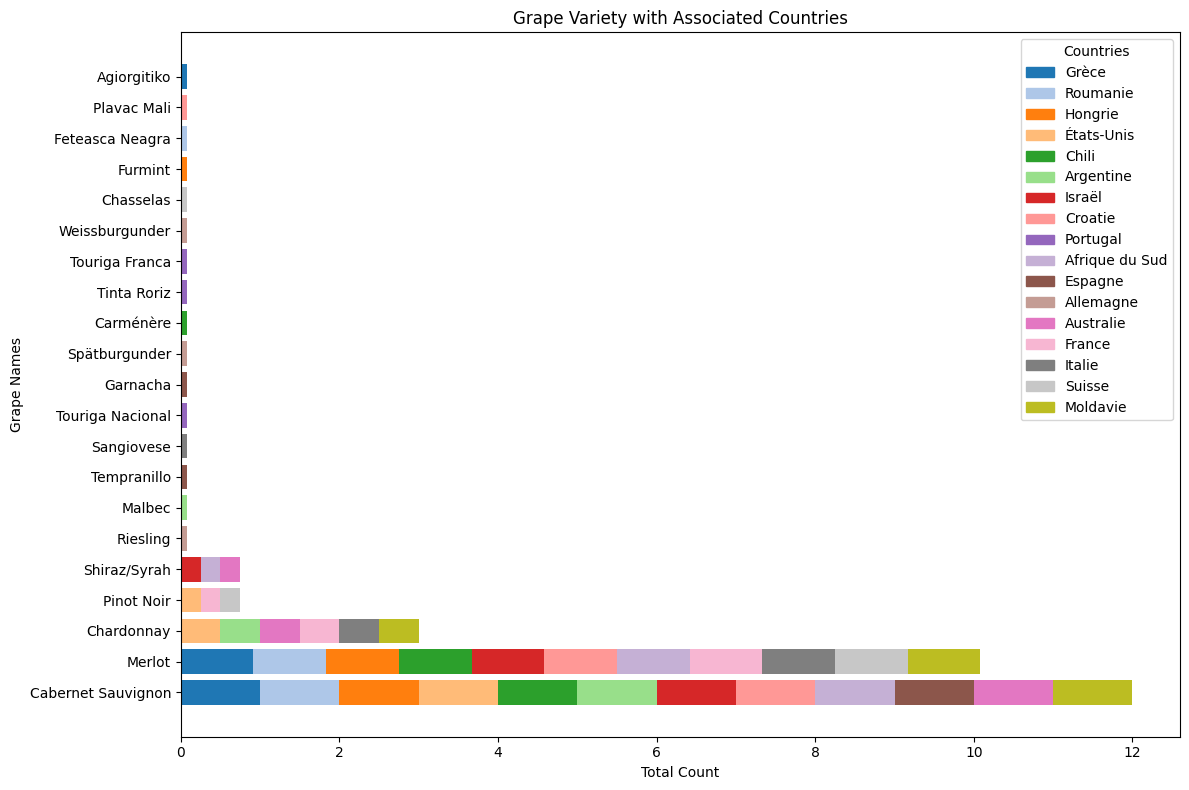

In [294]:
top_grapes_query = '''
    SELECT 
        grapes.name AS grape_name,
        GROUP_CONCAT(countries.name) AS countries_list,
        COUNT(most_used_grapes_per_country.grape_id) AS total_count,
        SUM(most_used_grapes_per_country.wines_count) AS wines_count
    FROM 
        most_used_grapes_per_country
    INNER JOIN 
        grapes ON most_used_grapes_per_country.grape_id = grapes.id
    INNER JOIN 
        countries ON most_used_grapes_per_country.country_code = countries.code
    GROUP BY 
        most_used_grapes_per_country.grape_id
    ORDER BY 
        SUM(most_used_grapes_per_country.wines_count) DESC
    LIMIT 25
'''

cur.execute(top_grapes_query)
top_grapes_results = cur.fetchall()

grape_names = []
total_counts = []
countries_list = []

for row in top_grapes_results:
    grape_name, countries, total_count, _ = row
    grape_names.append(grape_name)
    total_counts.append(total_count)
    countries_list.append(countries.split(','))  

unique_countries = list(set(country for countries in countries_list for country in countries))
num_countries = len(unique_countries)

color_map = plt.get_cmap('tab20')

plt.figure(figsize=(12, 8))

for i, (grape_name, countries) in enumerate(zip(grape_names, countries_list)):
    segment_width = total_counts[i] / sum(total_counts)*4.25
    bottom = 0
    for j, country in enumerate(unique_countries):
        if country in countries:
            country_index = unique_countries.index(country)
            plt.barh(grape_name, segment_width, left=bottom, color=color_map(country_index), label=country)
            bottom += segment_width

handles = [plt.Rectangle((0,0),1,1, color=color_map(unique_countries.index(country))) for country in unique_countries]
plt.legend(handles, unique_countries, loc='upper right', title='Countries')

plt.xlabel('Total Count')
plt.ylabel('Grape Names')
plt.title('Grape Variety with Associated Countries')
plt.tight_layout()
plt.show()


In [442]:
df = pd.read_csv('data/wine_data.csv')

# Define the list of grape names to search for
grape_names_to_search = ['Cabernet Sauvignon', 'Chardonnay', 'Pinot Noir']  

# Iterate over each grape name
for grape_name in grape_names_to_search:
    matching_rows = df[df['grappe'] == grape_name]

    #print(f"Grape Name: {grape_name}")
    #print("Matching Rows:")
    #display(matching_rows)
    #print()
 
 

In [443]:

combined_df = pd.DataFrame()

for grape_name in grape_names_to_search:
    matching_rows = df[df['grappe'] == grape_name]

    wine_ids = matching_rows['wine_id'].tolist()

    # Query wine details from the database for the current grape and wine IDs
    cur.execute('''
        SELECT id, name, region_id, ratings_average, ratings_count
        FROM wines
        WHERE id IN ({})
    '''.format(','.join(map(str, wine_ids))))

    wine_details = cur.fetchall()

    wine_details_df = pd.DataFrame(wine_details, columns=['wine_id', 'name', 'region_id', 'ratings_average', 'ratings_count'])

    wine_details_df['grape'] = grape_name

    combined_df = pd.concat([combined_df, matching_rows.merge(wine_details_df, on='wine_id')])

for grape_name in grape_names_to_search:
    grape_df = combined_df[combined_df['grape'] == grape_name]

    sorted_grape_df = grape_df.sort_values(by='ratings_average', ascending=False)

    top_10_wines = sorted_grape_df.head(10).copy()  
    top_10_wines = top_10_wines.drop(columns=['name_x']).groupby('wine_id').first().reset_index()

    print(f"Top Wines and vintages for {grape_name}:")
    
    vintage_info_list = []

    for wine_id in top_10_wines['wine_id']:
        # Query vintage names and prices from the database for the current wine ID
        cur.execute('''
            SELECT name, ratings_average, price_euros
            FROM vintages
            WHERE wine_id = ?
            ORDER BY ratings_average DESC
            LIMIT 1
        ''', (wine_id,))

        vintage_info = cur.fetchone()

        vintage_info_list.append(vintage_info)

    vintage_info_df = pd.DataFrame(vintage_info_list, columns=['vintage_name', 'vintage_ratings_average', 'price_euro'])
    top_10_wines = pd.concat([top_10_wines.reset_index(drop=True), vintage_info_df], axis=1)
    top_10_wines = top_10_wines.sort_values(by='ratings_average', ascending=False)
    pd.set_option('display.max_colwidth', None)

    display(top_10_wines)
    print()


Top Wines and vintages for Cabernet Sauvignon:


,wine_id,id_vintage_id,country,region,wynnery,wine_color,grappe,name_y,region_id,ratings_average,ratings_count,grape,vintage_name,vintage_ratings_average,price_euro
5,1611255,14187320,États-Unis,Rutherford,Scarecrow,Vin rouge,Cabernet Sauvignon,Cabernet Sauvignon,105,4.8,2941,Cabernet Sauvignon,Scarecrow Cabernet Sauvignon 2015,4.8,1558.75
1,66294,150342955,États-Unis,Napa Valley,Caymus Vineyards,Vin rouge,Cabernet Sauvignon,Special Selection Cabernet Sauvignon,25,4.7,41236,Cabernet Sauvignon,Caymus Special Selection Cabernet Sauvignon 2017,4.7,443.00
3,1136930,86175320,Australie,Australie-Méridionale,Penfolds,Vin rouge,Cabernet Sauvignon,Grange,7,4.7,24356,Cabernet Sauvignon,Penfolds Grange 2015,4.7,739.00
4,1218210,1384432,États-Unis,Napa Valley,Harlan Estate,Vin rouge,Cabernet Sauvignon,Harlan Estate Red,25,4.7,7231,Cabernet Sauvignon,Harlan Estate Harlan Estate Red 1998,4.8,1921.25
0,4086,3953484,Chili,Puente Alto,Almaviva,Vin rouge,Cabernet Sauvignon,Almaviva,3068,4.6,48075,Cabernet Sauvignon,Almaviva Almaviva 2014,4.6,220.00
2,1127795,14160272,France,Margaux,Château Margaux,Vin rouge,Cabernet Sauvignon,Château Margaux (Premier Grand Cru Classé),384,4.6,45350,Cabernet Sauvignon,Château Margaux Château Margaux (Premier Grand Cru Classé) 2009,4.7,1067.50
6,1655970,3981026,France,Pauillac,Château Latour,Vin rouge,Cabernet Sauvignon,Grand Vin Pauillac (Premier Grand Cru Classé),393,4.6,38521,Cabernet Sauvignon,Château Latour Grand Vin Pauillac (Premier Grand Cru Classé) 2003,4.8,1686.25



Top Wines and vintages for Chardonnay:


,wine_id,id_vintage_id,country,region,wynnery,wine_color,grappe,name_y,region_id,ratings_average,ratings_count,grape,vintage_name,vintage_ratings_average,price_euro
5,9330771,171210355,France,Bâtard-Montrachet Grand Cru,Pierre Girardin,Vin blanc,Chardonnay,Batard-Montrachet Grand Cru,3036,4.8,34,Chardonnay,Pierre Girardin Batard-Montrachet Grand Cru 2020,0.0,1149.50
0,79635,98282,France,Champagne,Krug,Vin effervescent,Chardonnay,Clos du Mesnil,409,4.7,2471,Chardonnay,Krug Clos du Mesnil 1998,4.8,3522.50
1,79939,2392737,France,Montrachet Grand Cru,Domaine des Comtes Lafon,Vin blanc,Chardonnay,Montrachet Grand Cru,3041,4.7,516,Chardonnay,Domaine des Comtes Lafon Montrachet Grand Cru 2009,4.7,5977.50
2,1127349,1161459,France,Champagne Grand Cru Le Mesnil-sur-Oger,Salon,Vin effervescent,Chardonnay,Le Mesnil Blanc de Blancs (Cuvée S) Brut Champagne,4631,4.7,9564,Chardonnay,Salon Le Mesnil Blanc de Blancs (Cuvée S) Brut Champagne 1996,4.8,2882.50
3,1435787,16428173,France,Bâtard-Montrachet Grand Cru,Jean-Claude Ramonet,Vin blanc,Chardonnay,Montrachet Grand Cru,3041,4.7,459,Chardonnay,Jean-Claude Ramonet Montrachet Grand Cru 1987,0.0,11862.50
4,3102815,15955066,France,Champagne,Dom Pérignon,Vin effervescent,Chardonnay,P2 Plénitude Brut Champagne,409,4.7,7543,Chardonnay,Dom Pérignon P2 Plénitude Brut Champagne 2003,4.7,893.75



Top Wines and vintages for Pinot Noir:


,wine_id,id_vintage_id,country,region,wynnery,wine_color,grappe,name_y,region_id,ratings_average,ratings_count,grape,vintage_name,vintage_ratings_average,price_euro
1,83920,101629,France,Romanée-Saint-Vivant Grand Cru,Domaine de La Romanée-Conti,Vin rouge,Pinot Noir,Romanée-Saint-Vivant Grand Cru (Marey-Monge),2229,4.7,6597,Pinot Noir,Domaine de La Romanée-Conti Romanée-Saint-Vivant Grand Cru (Marey-Monge) 1999,4.7,10217.5
2,88177,1307260,France,Chambertin Grand Cru,Domaine Armand Rousseau,Vin rouge,Pinot Noir,Chambertin Grand Cru,2201,4.7,3401,Pinot Noir,Domaine Armand Rousseau Chambertin Grand Cru 2002,4.7,10960.0
4,1451400,4002778,France,Échezeaux Grand Cru,Henri Jayer,Vin rouge,Pinot Noir,Échézeaux Grand Cru,2221,4.7,359,Pinot Noir,Henri Jayer Échézeaux Grand Cru 1976,0.0,12886.5
0,16529,133317107,France,Musigny Grand Cru,Domaine Jacques Prieur,Vin rouge,Pinot Noir,Musigny Grand Cru,2217,4.6,739,Pinot Noir,Domaine Jacques Prieur Musigny Grand Cru 2015,4.8,1199.0
3,1187200,24821555,France,Musigny Grand Cru,Domaine Comte Georges de Vogüé,Vin rouge,Pinot Noir,Musigny Grand Cru (Cuveé Vieilles Vignes),2217,4.6,3533,Pinot Noir,Domaine Comte Georges de Vogüé Musigny Grand Cru (Cuveé Vieilles Vignes) 2017,4.7,1537.5
5,2114480,4221724,France,Champagne,Dom Pérignon,Vin effervescent,Pinot Noir,Brut Rosé Champagne,409,4.6,13747,Pinot Noir,Dom Pérignon Brut Rosé Champagne 2008,4.6,625.0
6,7294401,160862421,France,Clos de Tart Grand Cru,Mommessin,Vin rouge,Pinot Noir,Clos de Tart Grand Cru,2213,4.6,214,Pinot Noir,Mommessin Clos de Tart Grand Cru 2001,0.0,1082.5


In [439]:

grape_wines = {}

# DataFrame to store combined information
combined_df = pd.DataFrame()

# Iterate over each grape name
for grape_name in grape_names_to_search:
    matching_rows = df[df['grappe'] == grape_name]

    wine_ids = matching_rows['wine_id'].tolist()

    # Query wine details from the database for the current grape and wine IDs
    cur.execute('''
        SELECT id, name, region_id, ratings_average, ratings_count
        FROM wines
        WHERE id IN ({})
    '''.format(','.join(map(str, wine_ids))))

    wine_details = cur.fetchall()

    grape_wines[grape_name] = wine_details

    wine_details_df = pd.DataFrame(wine_details, columns=['wine_id', 'name', 'region_id', 'ratings_average', 'ratings_count'])

    wine_details_df['grape'] = grape_name

    combined_df = pd.concat([combined_df, matching_rows.merge(wine_details_df, on='wine_id')])

pd.set_option('display.max_rows', None)
#print("Combined Table:")
#display(combined_df)




In [324]:
grape_name_query = '''
    SELECT 
        name AS grape_name
    FROM 
        grapes
'''

cur.execute(grape_name_query)
grape_names = cur.fetchall()

for grape in grape_names:
    if grape[0] == 'Shiraz/Syrah':
        grape_name = 'Shiraz'
    else:
        grape_name = grape[0]  

    wine_name_query = '''
        SELECT 
            name, region_id
        FROM 
            wines
        WHERE 
            name LIKE ?
    '''
    cur.execute(wine_name_query, ('%' + grape_name + '%',))
    wine_names = cur.fetchall()

    vintage_name_query = '''
        SELECT 
            name
        FROM 
            vintages
        WHERE 
            name LIKE ?
    '''
    cur.execute(vintage_name_query, ('%' + grape_name + '%',))
    vintage_names = cur.fetchall()
    
    region_ids = []  

    print(f"Grape Name: {grape_name}")
    print("Wines:")
    for wine in wine_names:
        print(f"  - Wine: {wine[0]}, Region ID: {wine[1]}")
        region_ids.append(wine[1])  

    print("Vintages:")
    for vintage in vintage_names:
        print(f"  - {vintage[0]}")
        
    print("Region IDs:", region_ids)  
    print()


Grape Name: Shiraz
Wines:
  - Wine: St. Henri Shiraz, Region ID: 7
  - Wine: The Armagh Shiraz, Region ID: 444
  - Wine: Attunga 1865 Shiraz, Region ID: 444
  - Wine: Kevin Arnold Shiraz, Region ID: 533
  - Wine: Dogs of the Barossa Shiraz, Region ID: 870
  - Wine: RWT Bin 798 Shiraz, Region ID: 397
Vintages:
  - Penfolds St. Henri Shiraz 2016
  - Waterford Estate Kevin Arnold Shiraz 2016
  - Penfolds St. Henri Shiraz 2018
  - RedHeads Dogs of the Barossa Shiraz 2018
  - Jim Barry The Armagh Shiraz 2018
  - Kilikanoon Attunga 1865 Shiraz 2018
  - Penfolds RWT Bin 798 Shiraz 2018
Region IDs: [7, 444, 444, 533, 870, 397]

Grape Name: Cabernet Sauvignon
Wines:
  - Wine: Cabernet Sauvignon (Signature), Region ID: 25
  - Wine: Chateau Buena Vista Cabernet Sauvignon Napa Valley, Region ID: 25
  - Wine: Cabernet Sauvignon, Region ID: 25
  - Wine: Cabernet Sauvignon, Region ID: 460
  - Wine: Cabernet Sauvignon, Region ID: 25
  - Wine: Special Selection Cabernet Sauvignon, Region ID: 25
  - Win

In [396]:
grape_name_query = '''
    SELECT 
        name AS grape_name
    FROM 
        grapes
'''

cur.execute(grape_name_query)
grape_names = cur.fetchall()

# Iterate over each grape
for grape in grape_names:
    if grape[0] == 'Shiraz/Syrah':
        grape_name = 'Shiraz'
    else:
        grape_name = grape[0]  

    # SQL query to retrieve region IDs for the current grape
    region_id_query = '''
        SELECT 
            DISTINCT region_id
        FROM 
            wines
        WHERE 
            name LIKE ?
    '''
    cur.execute(region_id_query, ('%' + grape_name + '%',))
    region_ids = [row[0] for row in cur.fetchall()]

    # SQL query to retrieve wine names based on region IDs for the current grape
    wine_query = '''
        SELECT 
            name
        FROM 
            wines
        WHERE 
            region_id IN ({})
    '''.format(','.join(['?'] * len(region_ids)))

    cur.execute(wine_query, region_ids)
    wine_names = cur.fetchall()

    print(f"Grape Name: {grape_name}")
    print("Wine Names:")
    for wine in wine_names:
        print(f"  - {wine[0]}")
    print()




Grape Name: Shiraz
Wine Names:
  - St. Henri Shiraz
  - Aphrodite
  - The Stork
  - 1694 Classification Red
  - The Armagh Shiraz
  - Nine Popes
  - Attunga 1865 Shiraz
  - Grange
  - The Laird
  - V Red
  - Book 17 XVII
  - Ares
  - B Bordicon Blend
  - Faith
  - Kevin Arnold Shiraz
  - The Mackenzie
  - Pinotage
  - Fusion V
  - The Black Lion
  - Dogs of the Barossa Shiraz
  - RWT Bin 798 Shiraz
  - Crescendo
  - 802.A Superblend

Grape Name: Cabernet Sauvignon
Wine Names:
  - Chardonnay
  - Cabernet Sauvignon (Signature)
  - Merlot (Signature)
  - Overture
  - Rutherford
  - Chateau Buena Vista Cabernet Sauvignon Napa Valley
  - Relentless
  - Papillon
  - IX Estate Red
  - Lot 1
  - Dominus (Christian Moueix)
  - Cabernet Sauvignon
  - Insignia
  - Cabernet Sauvignon
  - Cabernet Sauvignon
  - Special Selection Cabernet Sauvignon
  - Gewürztraminer Lunare
  - Veneto Rosso del Bepi
  - Beckstoffer To Kalon Vineyard Cabernet Sauvignon
  - Beyond the Clouds
  - Cabernet Sauvignon Coe

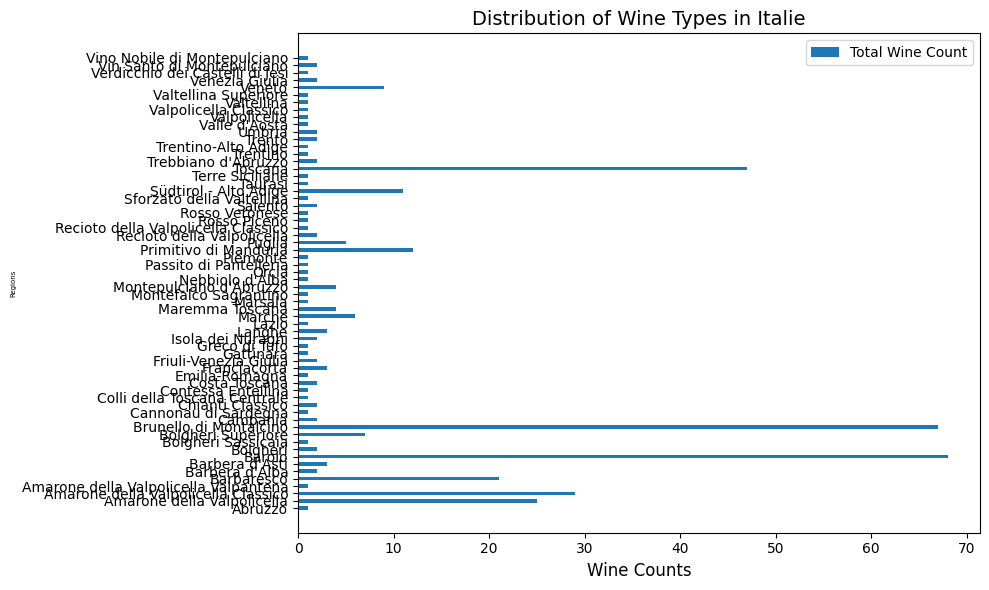

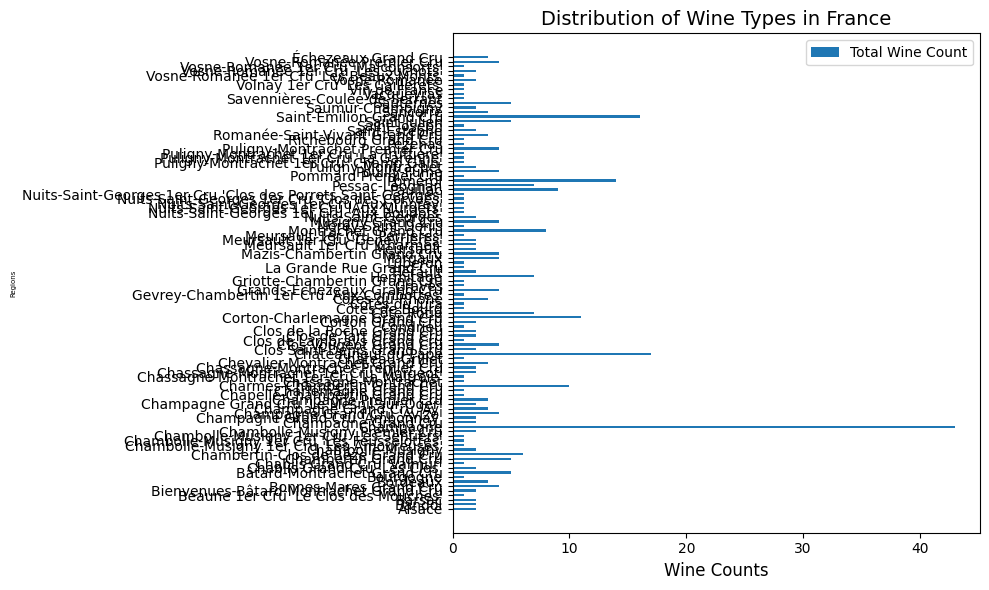

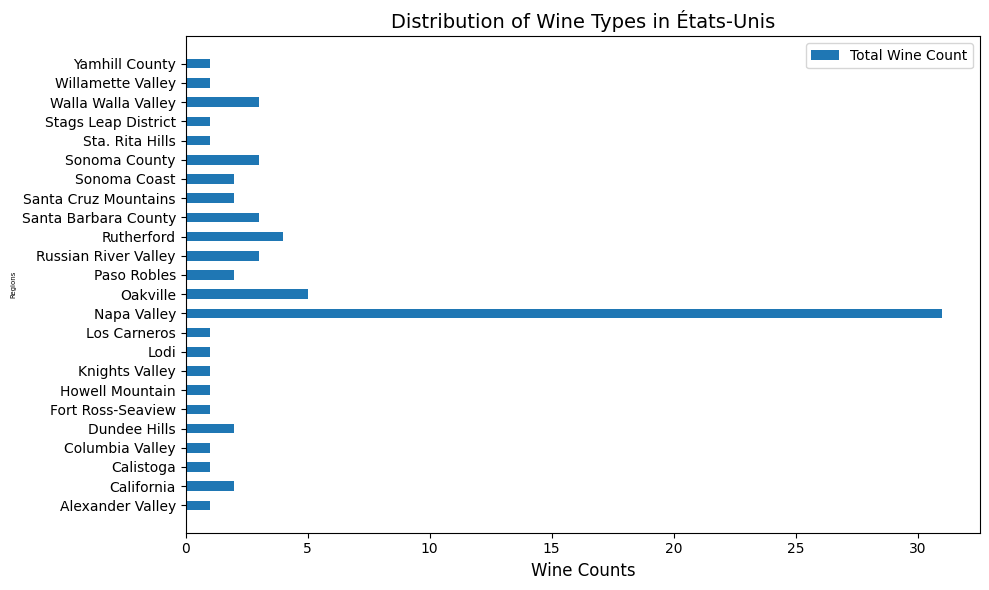

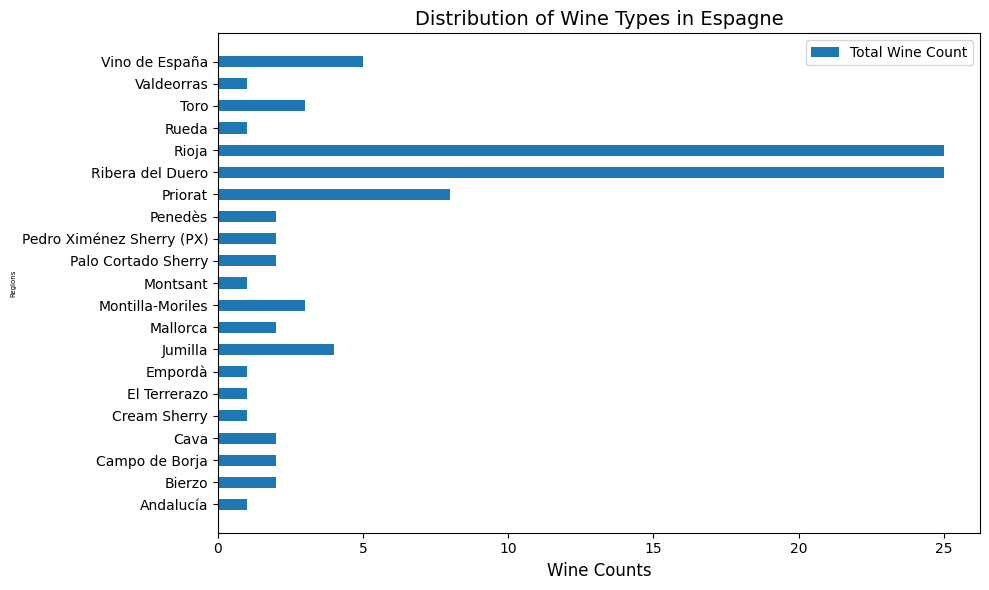

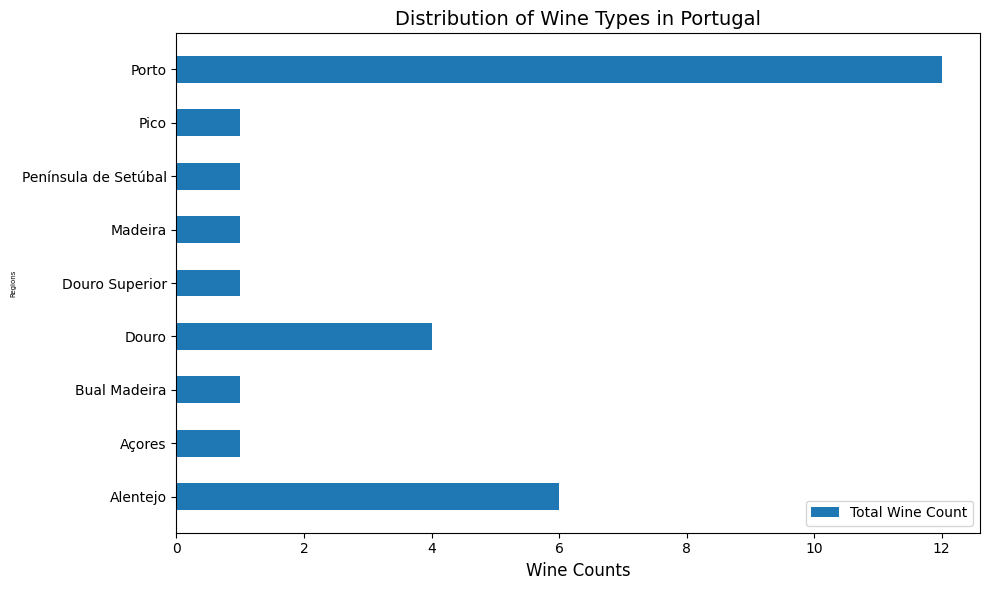

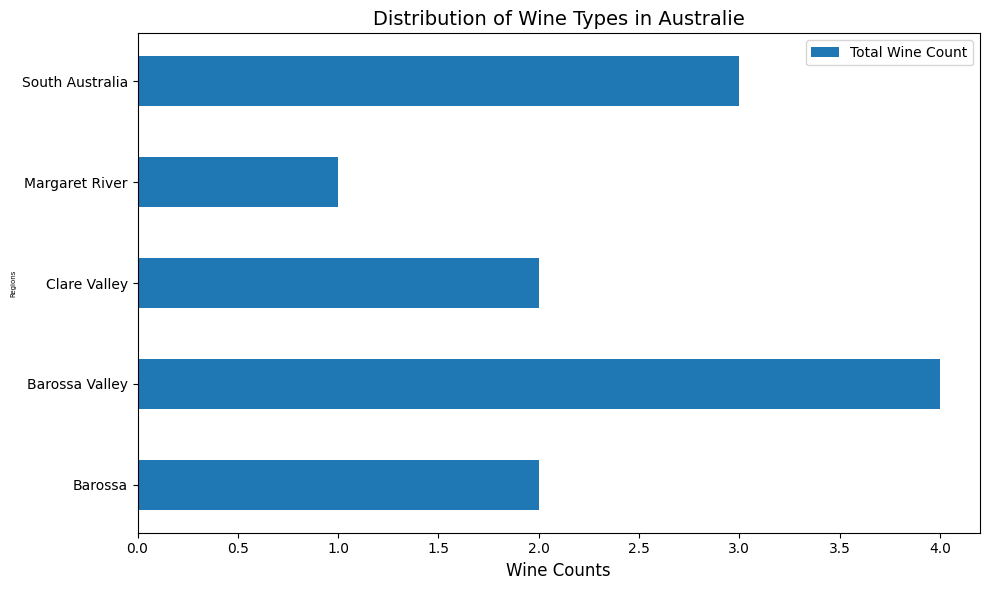

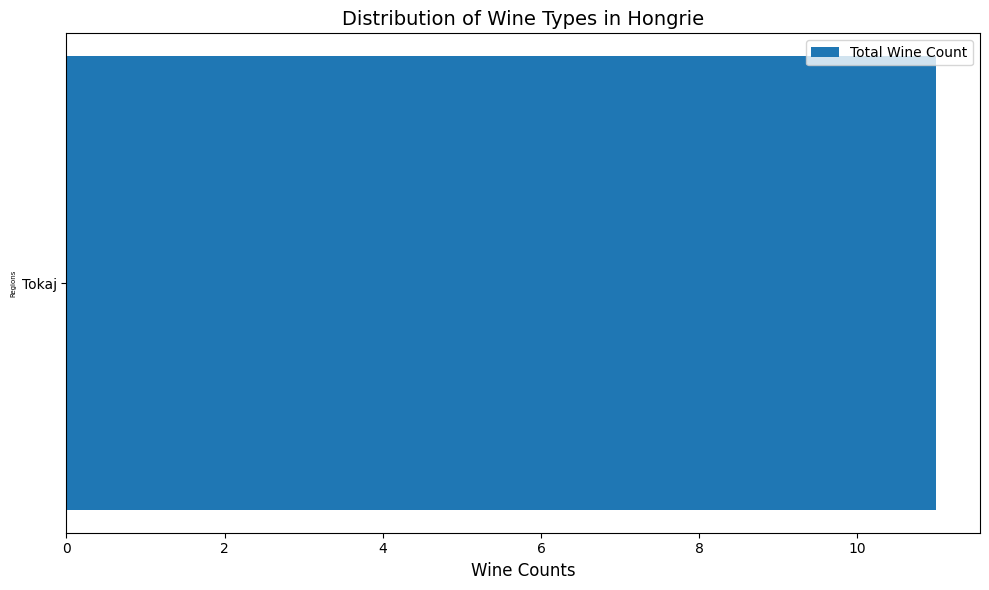

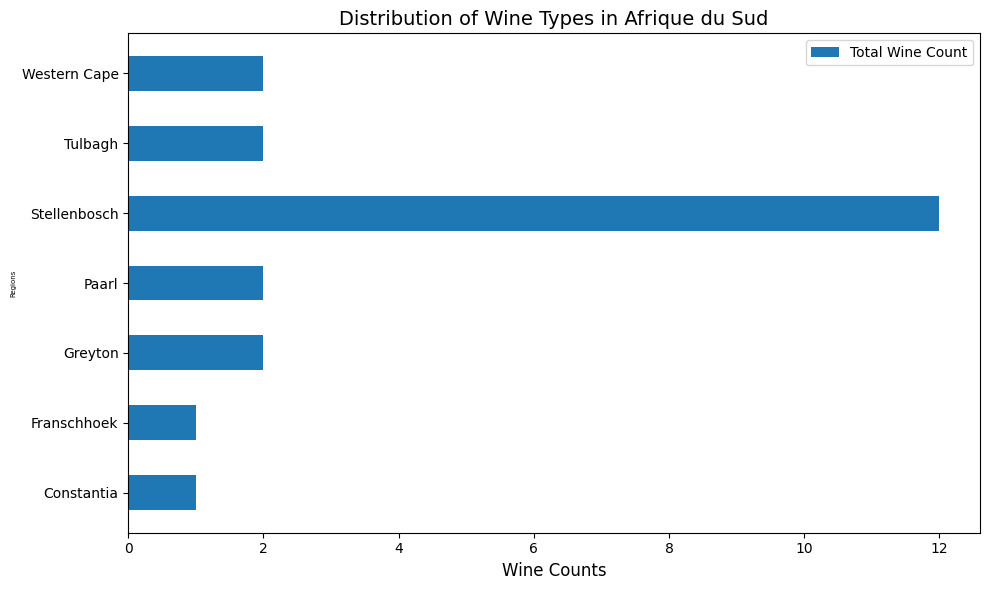

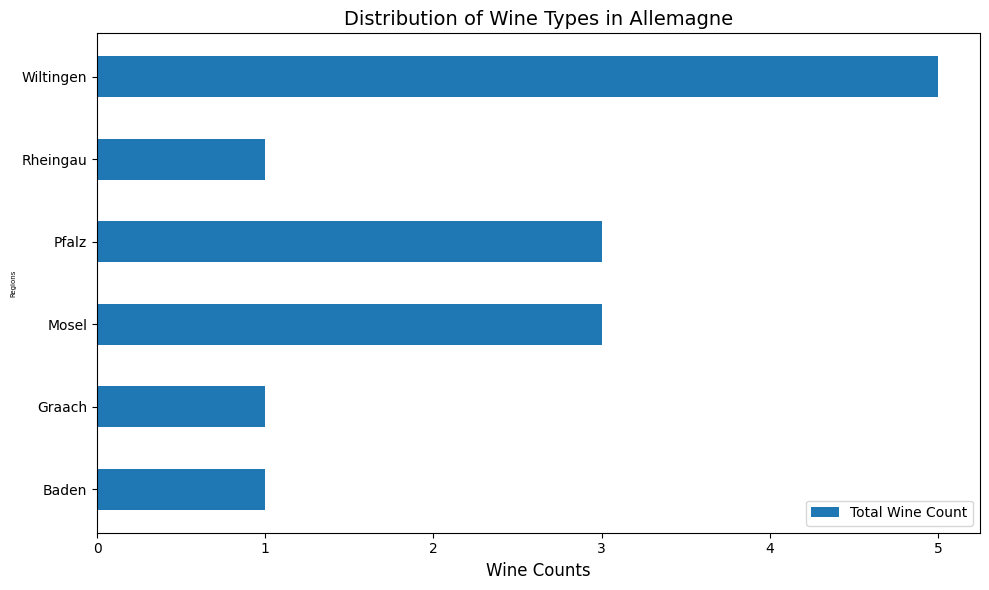

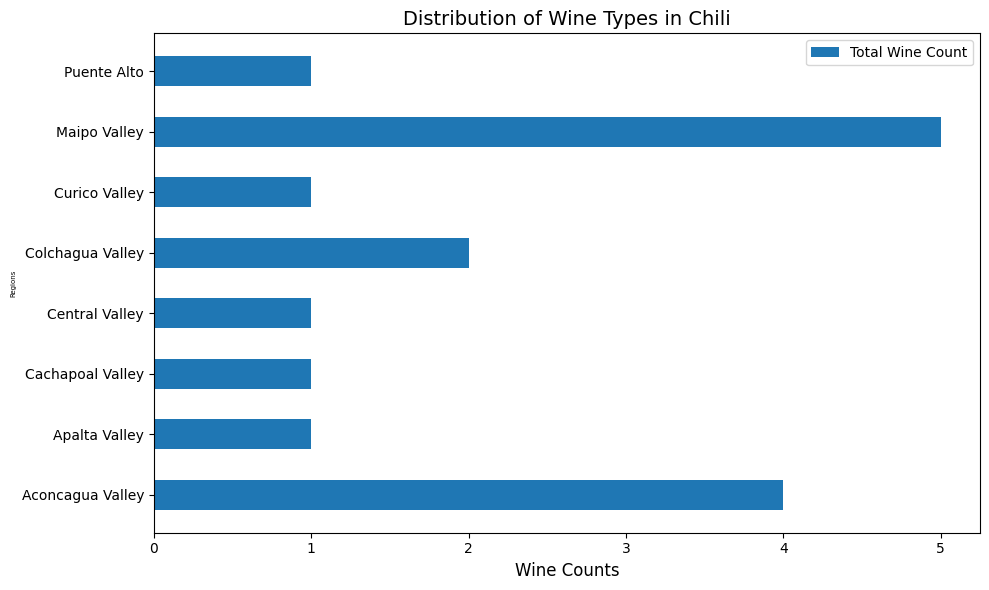

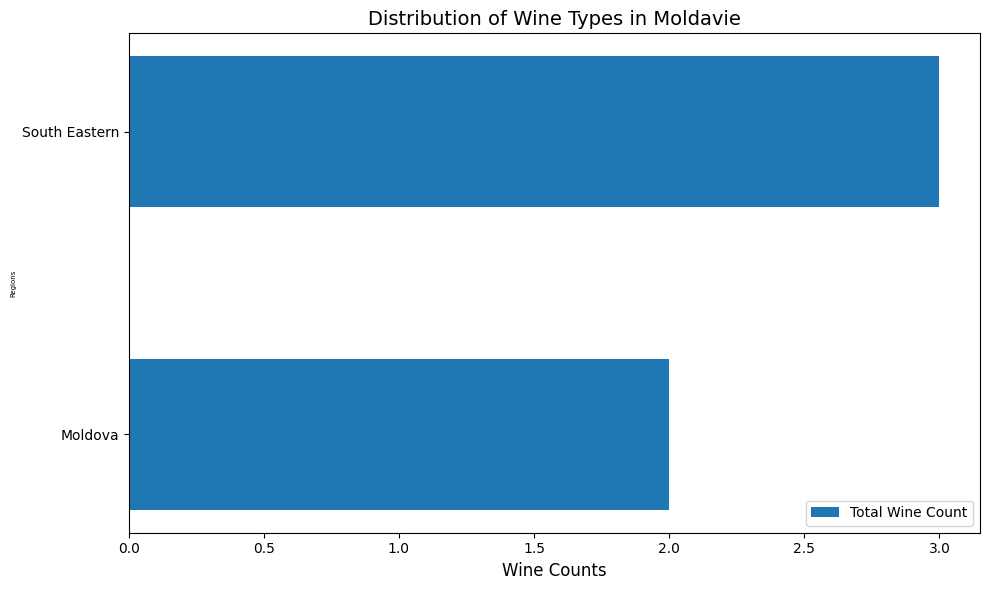

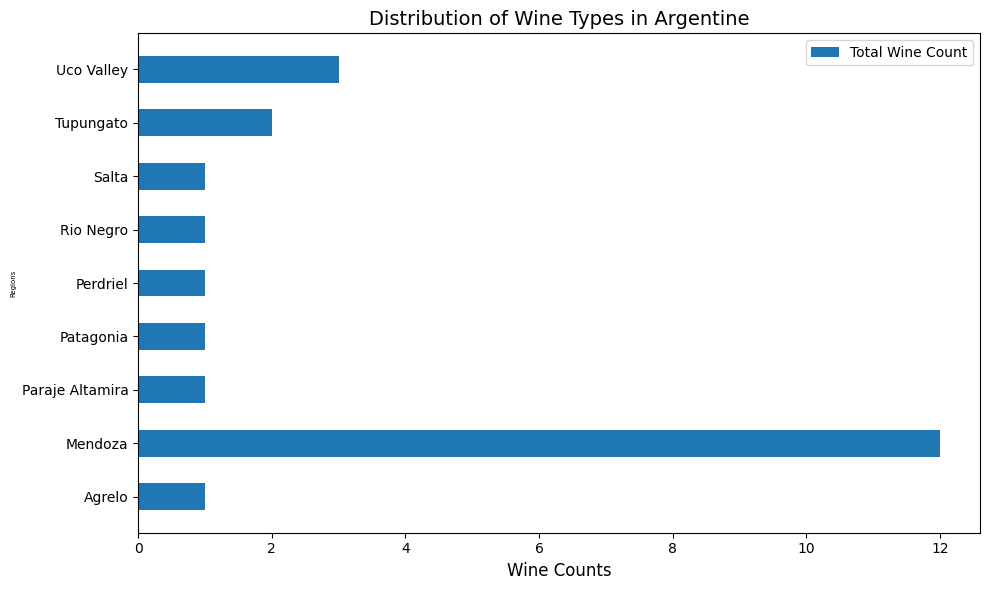

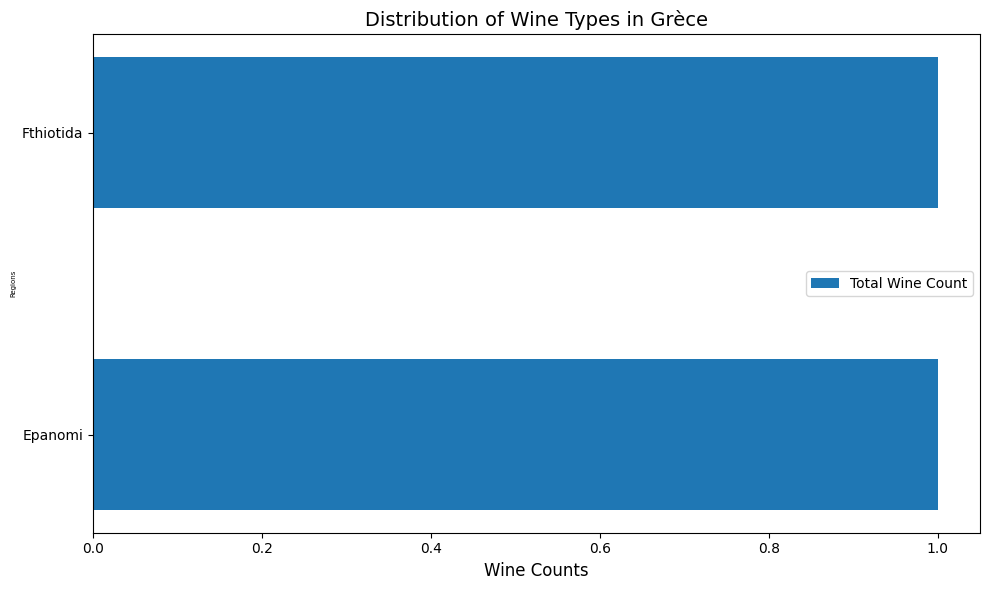

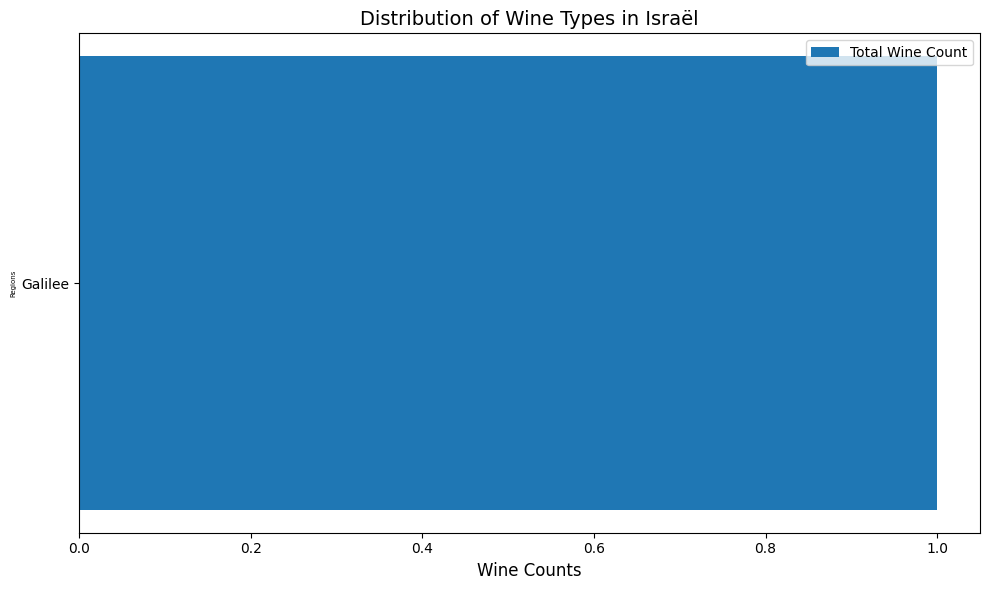

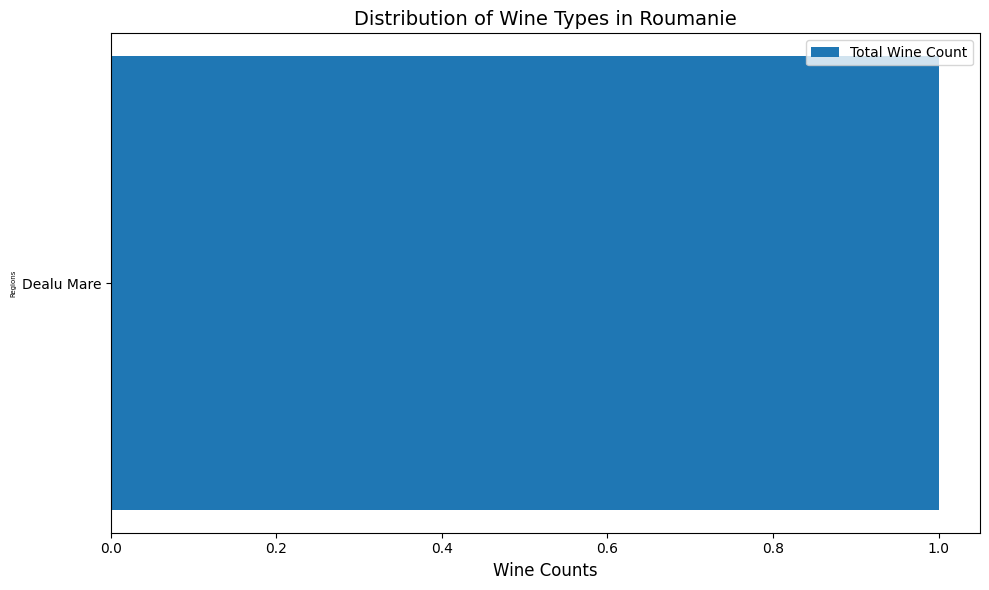

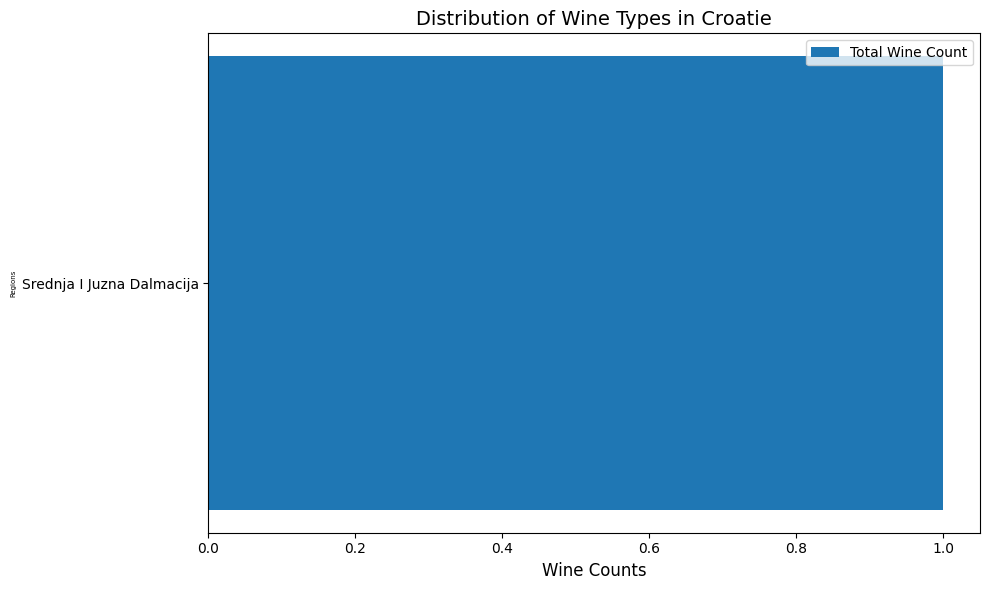

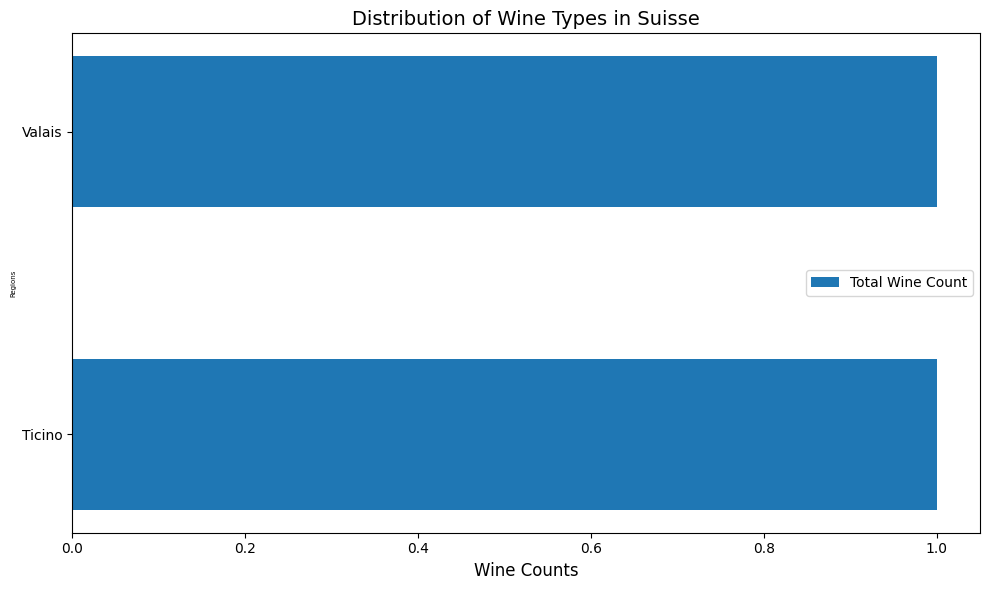

In [377]:

def wine_types_query(country):
    return f'''
        SELECT 
            regions.name AS region,
            COUNT(wines.id) AS wine_count
        FROM 
            regions
        JOIN 
            wines ON regions.id = wines.region_id
        JOIN 
            countries ON regions.country_code = countries.code
        WHERE
            countries.name = '{country}'
        GROUP BY 
            regions.name
    '''

cur.execute("SELECT DISTINCT name FROM countries")
countries = [row[0] for row in cur.fetchall()]

for country in countries:
    cur.execute(wine_types_query(country))
    wine_types_results = cur.fetchall()

    regions = [row[0] for row in wine_types_results]
    wine_counts = [row[1] for row in wine_types_results]

    # Plot stacked bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(regions, wine_counts, height=0.5, label='Total Wine Count')

    # Add labels and title with custom font size
    plt.xlabel('Wine Counts', fontsize=12)
    plt.ylabel('Regions', fontsize=5)
    plt.title(f'Distribution of Wine Types in {country}', fontsize=14)
    plt.legend()

    # Adjust tick font size
    plt.xticks(fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()


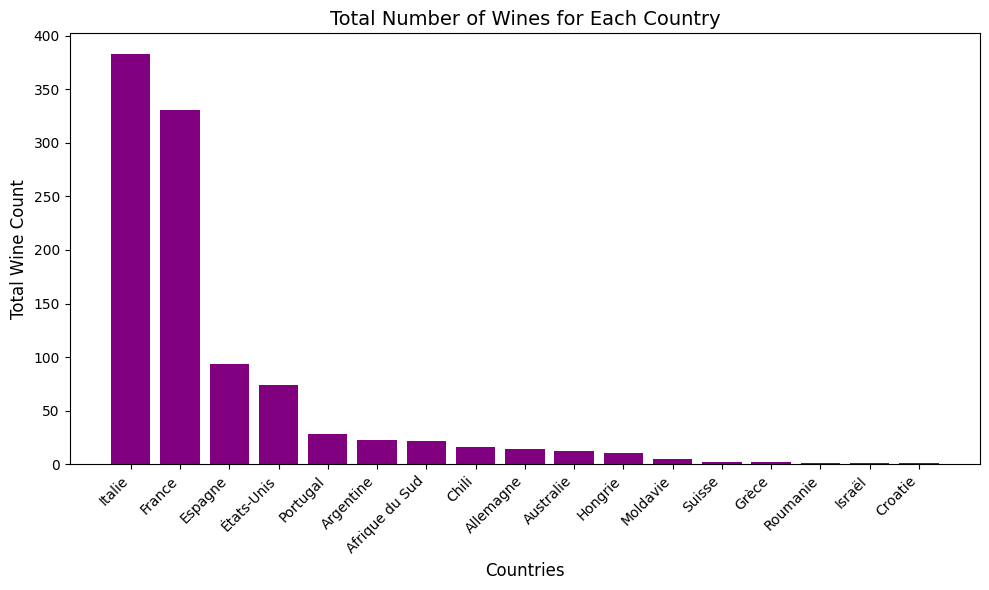

In [458]:
def total_wine_count_per_country():
    return '''
        SELECT 
            countries.name AS country,
            COUNT(wines.id) AS total_wine_count
        FROM 
            countries
        LEFT JOIN 
            regions ON countries.code = regions.country_code
        LEFT JOIN 
            wines ON regions.id = wines.region_id
        GROUP BY 
            countries.name
        ORDER BY 
            total_wine_count DESC
    '''

# Execute the query
cur.execute(total_wine_count_per_country())
total_wine_counts = cur.fetchall()

# Extract country names and total wine counts
countries = [row[0] for row in total_wine_counts]
wine_counts = [row[1] for row in total_wine_counts]

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(countries, wine_counts, color='purple')
plt.xlabel('Countries', fontsize=12)
plt.ylabel('Total Wine Count', fontsize=12)
plt.title('Total Number of Wines for Each Country', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


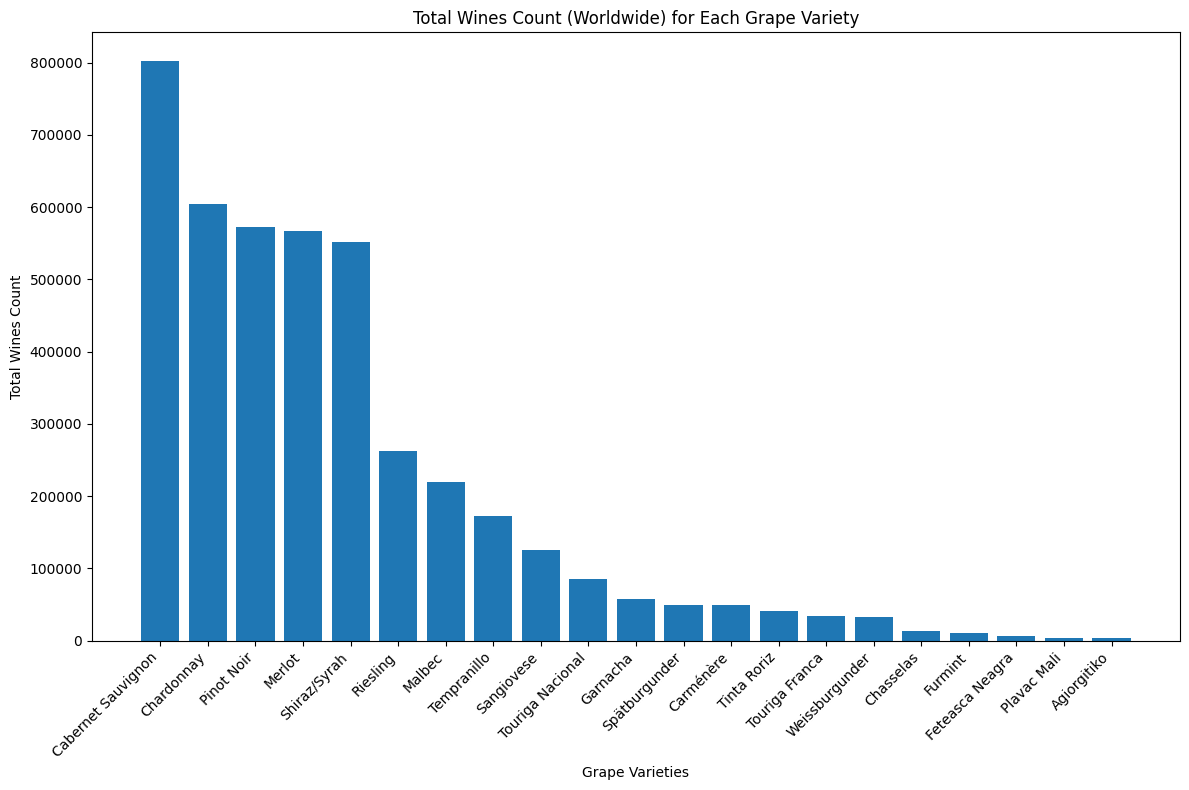

In [293]:
grape_wine_count_query = '''
    SELECT 
        grapes.name AS grape_name,
        most_used_grapes_per_country.wines_count AS total_wines_count
    FROM 
        most_used_grapes_per_country
    INNER JOIN 
        grapes ON most_used_grapes_per_country.grape_id = grapes.id
    GROUP BY 
        grape_name
    ORDER BY 
        total_wines_count DESC
'''

cur.execute(grape_wine_count_query)
grape_wine_count_results = cur.fetchall()

grape_names = [result[0] for result in grape_wine_count_results]
total_wine_counts = [result[1] for result in grape_wine_count_results]

plt.figure(figsize=(12, 8))
plt.bar(grape_names, total_wine_counts)
plt.xlabel('Grape Varieties')
plt.ylabel('Total Wines Count')
plt.title('Total Wines Count (Worldwide) for Each Grape Variety')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [440]:
for grape_result in top_grapes_results:
    grape_name = grape_result[0]
    top_wines_query = '''
        SELECT 
            wines.name AS wine_name,
            wines.ratings_average AS rating,
            wines.ratings_count
        FROM 
            wines
        INNER JOIN 
            regions ON wines.region_id = regions.id
        INNER JOIN 
            countries ON regions.country_code = countries.code
        INNER JOIN 
            most_used_grapes_per_country ON countries.code = most_used_grapes_per_country.country_code
        INNER JOIN 
            grapes ON most_used_grapes_per_country.grape_id = grapes.id
        WHERE 
            grapes.name = ?
        ORDER BY 
            wines.ratings_average DESC
        LIMIT 5
    '''
    cur.execute(top_wines_query, (grape_name,))
    top_wines_results = cur.fetchall()
    
    headers = ["Wine Name", "Rating", "rating_count"]
    #print(tabulate(top_wines_results, headers=headers))
    #print()

### We would like to create a country leaderboard. Come up with a visual that shows the average wine rating for each country. Do the same for the vintages.

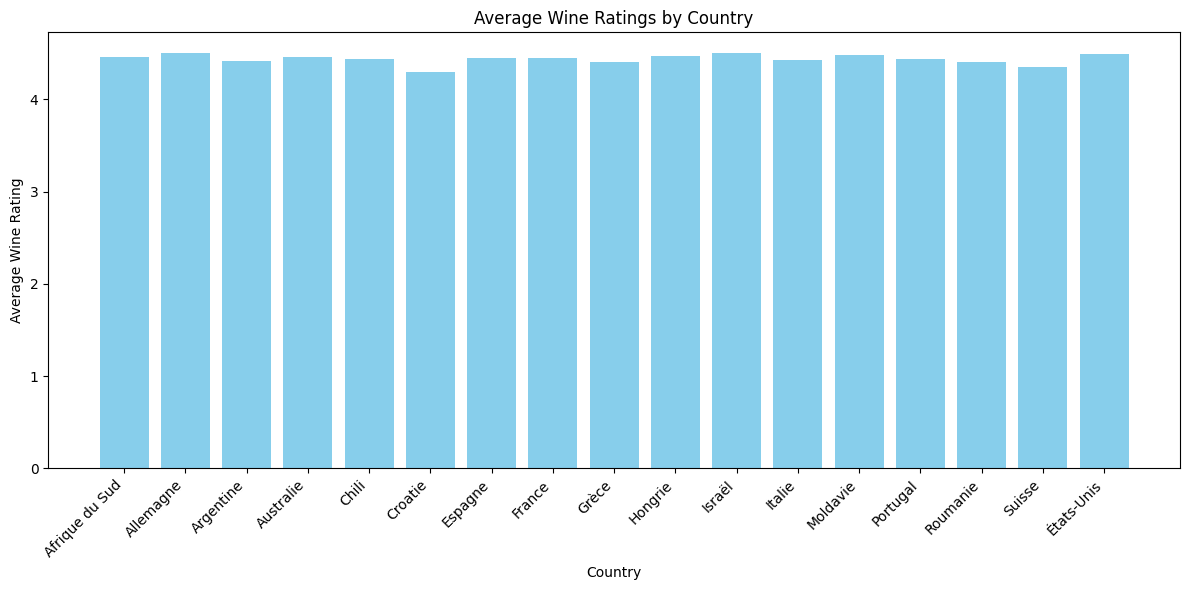

In [281]:
country_query = '''
    SELECT 
        countries.name AS country,
        AVG(wines.ratings_average) AS avg_rating
    FROM 
        countries
    JOIN 
        regions ON countries.code = regions.country_code
    JOIN 
        wines ON regions.id = wines.region_id
    GROUP BY 
        countries.name
'''

cur.execute(country_query)
country_results = cur.fetchall()

country_names = [row[0] for row in country_results]
avg_ratings_country = [row[1] for row in country_results]

plt.figure(figsize=(12, 6))
plt.bar(country_names, avg_ratings_country , color='skyblue')
plt.xlabel('Country')
plt.ylabel('Average Wine Rating')
plt.title('Average Wine Ratings by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



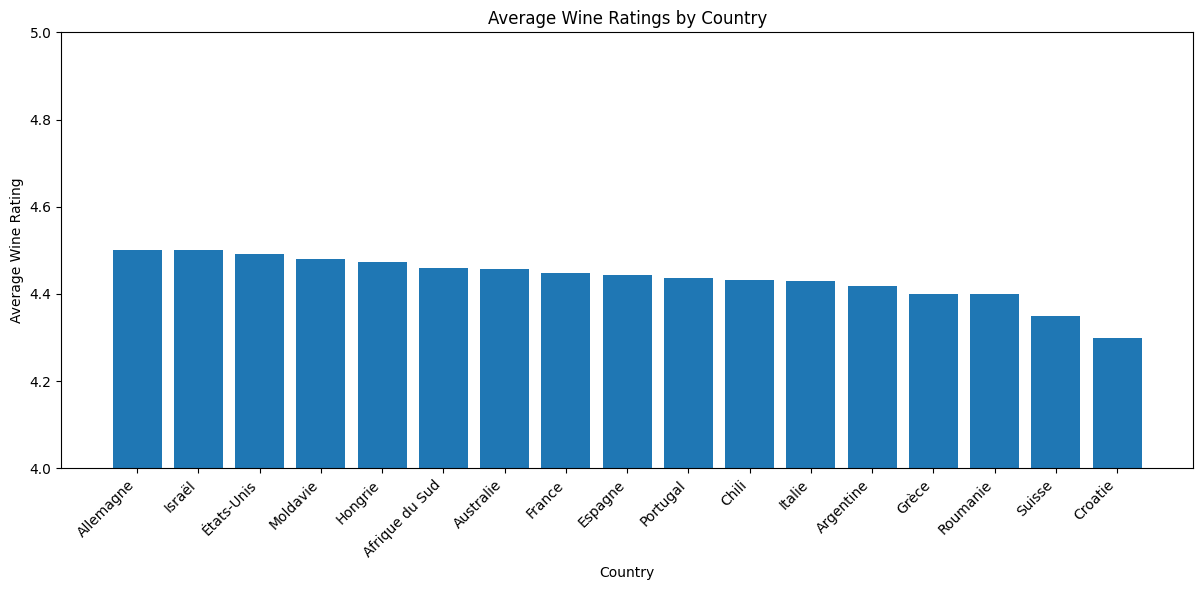

In [287]:
country_query = '''
    SELECT 
        countries.name AS country,
        AVG(wines.ratings_average) AS avg_rating
    FROM 
        countries
    JOIN 
        regions ON countries.code = regions.country_code
    JOIN 
        wines ON regions.id = wines.region_id
    GROUP BY 
        countries.name
'''

cur.execute(country_query)
country_results = cur.fetchall()

country_results_sorted = sorted(country_results, key=lambda x: x[1], reverse=True)

country_names = [row[0] for row in country_results_sorted]
avg_ratings_country = [row[1] for row in country_results_sorted]

plt.figure(figsize=(12, 6))
plt.bar(country_names, avg_ratings_country)
plt.xlabel('Country')
plt.ylabel('Average Wine Rating')
plt.title('Average Wine Ratings by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.ylim(4, max(avg_ratings_country) + 0.5)  

plt.show()


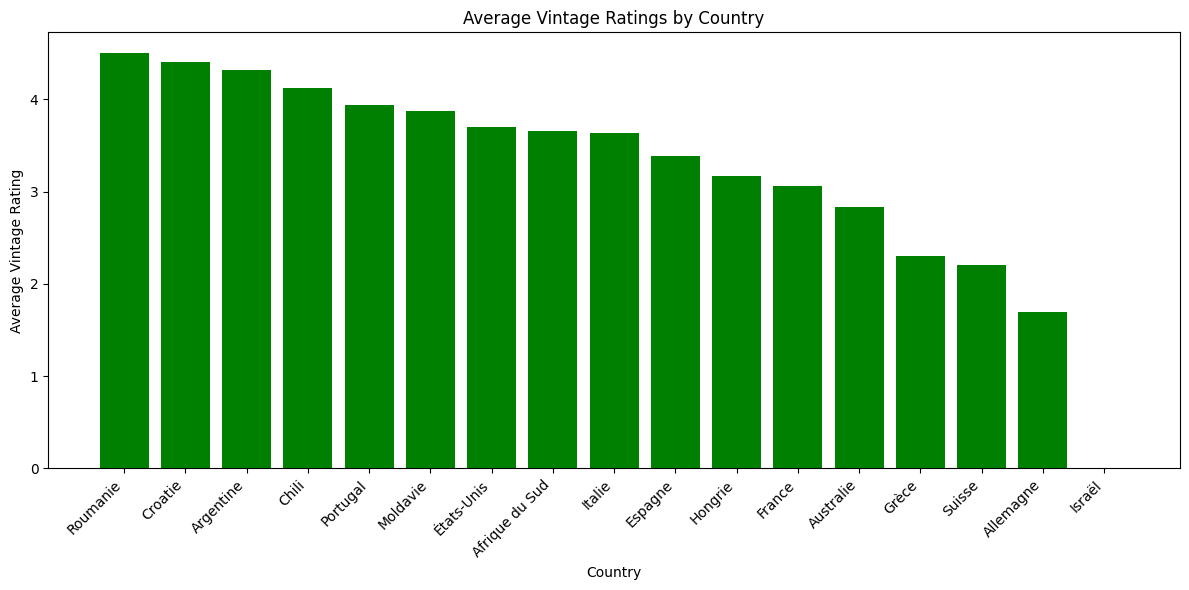

In [292]:
vintage_query = '''
    SELECT 
        countries.name AS country,
        AVG(vintages.ratings_average) AS avg_rating
    FROM 
        countries
    JOIN 
        regions ON countries.code = regions.country_code
    JOIN 
        wines ON regions.id = wines.region_id
    JOIN
        vintages ON wines.id = vintages.wine_id
    GROUP BY 
        countries.name
'''

cur.execute(vintage_query)
vintage_results = cur.fetchall()

vintage_results_sorted = sorted(vintage_results, key=lambda x: x[1], reverse=True)

vintage_names = [row[0] for row in vintage_results_sorted]
avg_ratings_vintage = [row[1] for row in vintage_results_sorted]

plt.figure(figsize=(12, 6))
plt.bar(vintage_names, avg_ratings_vintage, color='green')
plt.xlabel('Country')
plt.ylabel('Average Vintage Rating')
plt.title('Average Vintage Ratings by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
